In [18]:
### Import packages 
import networkx as nx # for handling graphs/networks 
import numpy as np # for basic scientific computing 
import pandas as pd # for basic scientific computing 
import matplotlib.pyplot as plt # for plotting
import matplotlib.gridspec as gridspec
from scipy.integrate import ode
from sklearn.cluster import KMeans

import seaborn as sns

from scipy.special import binom
from scipy.linalg import subspace_angles

from scipy.integrate import solve_ivp
import Koopman_source as kp
from math import comb
#from copy import copy
import csv  
from scipy.optimize import minimize
from scipy.special import expit


In [19]:
np.random.seed(123)

## Compute a Koopman matrix from simulated data.

#x0 = [2,1]

model = "Duffing"
sequential = False

if model == "d2_ans":
    d = 2
elif model == "d2":
    d = 2 # the number of variables (=the dimension) of the original dynamical system.
elif model == "d3":
    d = 3
elif model == "Lorenz":
    d = 3
elif model == "Lotka_Voltera":
    d = 2
elif model == "Duffing":
    d = 2

#M = 100 # the number of observed data. 

orth_basis = True

M_max = 2000 # the maximum number of observed data. 
n_repeat = 2 # the number of repetition of approximaing the Koopman matrix. 
max_order = 7
N = comb(d+max_order,d) # the total number of observable functions, psi_m's. 
# N1 = 4 
# N2 = N - N1

In [20]:

alpha0 = -1
beta0 = 1
delta0 = 0.3 # Damping parameter
# delta0 = 0.0 # Damping parameter
dt = 0.05

# Set parameters
M1, M2 = 10**2, 5  # number of data points
M_max = M1*M2
N = 100

x_mat_total = np.zeros([d,M_max])
y_mat_total = np.zeros([d,M_max])

for m1 in range(M1):
    x_mat_total[:, m1*M2] = np.random.uniform(-2, 2, size=(d, ))
    for m2 in range(M2-1):
        x_mat_total[:, m1*M2+m2+1] = kp.Duffing(x_mat_total[:, m1*M2+m2], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)

K_approx = np.zeros([N,N,M_max])
G_approx = np.zeros([N,N,M_max])
G_pinv = np.zeros([N,N,M_max])
A_approx = np.zeros([N,N,M_max])

for i in range(M_max):
    y_mat_total[:,i] = kp.Duffing(x_mat_total[:,i], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)


# Scaling for radial function
gamma_inv_scale = np.mean(np.linalg.norm(x_mat_total - np.mean(x_mat_total, axis=1)[:, np.newaxis], axis=0))

# Find centers using KMeans
kmeans = KMeans(n_clusters=N, random_state=0).fit(np.vstack((x_mat_total.T, y_mat_total.T)))
Cj = kmeans.cluster_centers_


Psi_X = np.zeros([M_max,N])
Psi_Y = np.zeros([M_max,N])

for i in range(M_max):
    for j in range(N):
        Psi_X[i,j] = kp.psi_radial(x_mat_total[:,i], Cj[j,:], 1/gamma_inv_scale)
        Psi_Y[i,j] = kp.psi_radial(y_mat_total[:,i], Cj[j,:], 1/gamma_inv_scale)

G_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_X[np.ix_(range(1),range(N))])
G_pinv[:,:,0] = np.linalg.pinv(G_approx[:,:,0])
A_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_Y[np.ix_(range(1),range(N))])
K_approx[:,:,0] = np.matmul(G_pinv[:,:,0], A_approx[:,:,0])

for M in range(2,M_max+1):  
    G_approx[:,:,M-1] = G_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_X[np.ix_(range(M-1,M),range(N))])
    G_pinv[:,:,M-1] = np.linalg.pinv(G_approx[:,:,M-1])
    A_approx[:,:,M-1] = A_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_Y[np.ix_(range(M-1,M),range(N))])
    K_approx[:,:,M-1] = np.matmul(G_pinv[:,:,M-1], A_approx[:,:,M-1])


/opt/anaconda3/envs/py_base/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


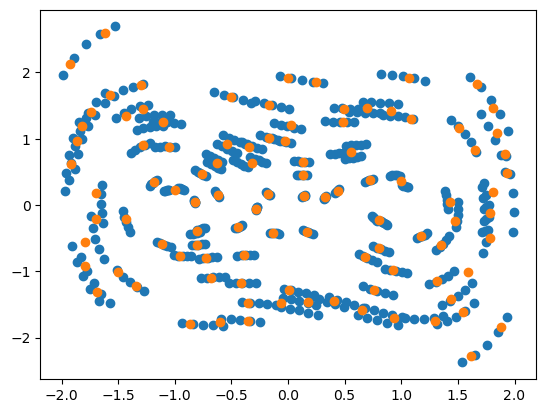

In [21]:
plt.scatter(x_mat_total[0,:],x_mat_total[1,:])
# plt.scatter(y_mat_total[0,:],y_mat_total[1,:])
plt.scatter(Cj[:,0],Cj[:,1])
# x_mat_total.shape



In [22]:
x_mat_total[:,3]
# Cj[5,:]

array([ 0.66179868, -0.76874628])

Text(978.81045751634, 0.5, 'Rows')

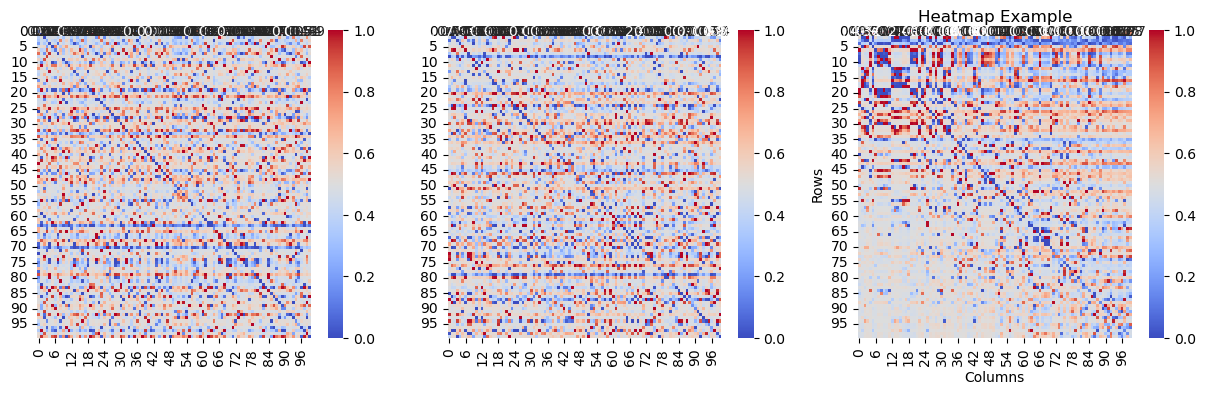

In [23]:
mixed_idx = np.random.permutation(N)

K_approx_one = K_approx[:,:,M_max-1]
K_approx_one = 1/dt * (np.squeeze(K_approx_one) - np.identity(N))

eig_v = kp.pagerank(abs(K_approx_one), 50000, 0.7)
eig_v2 = kp.subsampled_pagerank(abs(K_approx_one), 50000, 0.7, 0.3)
ranked_idx = np.argsort(eig_v)[::-1]
ranked_idx2 = np.argsort(eig_v2)[::-1]

K_approx_one_mx = K_approx_one[np.ix_(mixed_idx,mixed_idx)]
# K_approx_one_mx = 1/dt * (np.squeeze(K_approx_one_mx) - np.identity(N))

K_approx_one_pr = K_approx_one[np.ix_(ranked_idx,ranked_idx)]
# K_approx_one_pr = 1/dt * (np.squeeze(K_approx_one_pr) - np.identity(N))

K_approx_one_subpr = K_approx_one[np.ix_(ranked_idx2,ranked_idx2)]
# K_approx_one_subpr = 1/dt * (np.squeeze(K_approx_one_subpr) - np.identity(N))

# Create a heatmap
#fig2, ax2 = plt.subplots(len(i_list), len(j_list), figsize = (8,8))
fig1, ax1 = plt.subplots(1,3,figsize = (15,4))
#plt.figure(figsize=(8, 6))
color_scale = 5
sns.heatmap(expit(K_approx_one*color_scale), ax=ax1[0], annot=True, cmap='coolwarm', cbar=True)
sns.heatmap(expit(K_approx_one_mx*color_scale), ax=ax1[1], annot=True, cmap='coolwarm', cbar=True)
sns.heatmap(expit(K_approx_one_pr*color_scale), ax=ax1[2], annot=True, cmap='coolwarm', cbar=True)# sns.heatmap(expit(data_subpr*10), ax=ax1[2], annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(expit(K_approx_one_pr*100), annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(1/(1+np.exp(-K_approx_one)), annot=True, cmap='coolwarm', cbar=True)

# Add title and labels
plt.title("Heatmap Example")
plt.xlabel("Columns")
plt.ylabel("Rows")


In [24]:
# Computing the subspace angles with increasing number of (ordered) basis functions.

subsp_ang_mx = np.zeros(N)
subsp_ang_inc = np.zeros(N)
subsp_ang_pr = np.zeros(N)
subsp_ang_subpr = np.zeros(N)

M_ang = 1000
# dataX_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
# dataY_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
dataX_for_angle = np.random.default_rng(12).uniform(-2, 2, size=(d, M_ang))
dataY_for_angle = np.random.default_rng(13).uniform(-2, 2, size=(d, M_ang))
# 

Psi_X_ang = np.zeros([M_ang,N])
Psi_Y_ang = np.zeros([M_ang,N])

for i in range(M_ang):
    dataY_for_angle[:,i] = kp.Duffing(dataX_for_angle[:,i], alpha0=alpha0, beta0 = beta0, delta0 = delta0, dt = dt)

for i in range(M_ang):
    for j in range(N):
        Psi_X_ang[i,j] = kp.psi_radial(dataX_for_angle[:,i], Cj[j,:], 1/gamma_inv_scale)
        Psi_Y_ang[i,j] = kp.psi_radial(dataY_for_angle[:,i], Cj[j,:], 1/gamma_inv_scale)

for N_vary in range(2,N):
    # x_mat_total = np.random.default_rng().exponential(scale=1, size=[d,M_max])
    # Psi_Y_ang = np.matmul(Psi_X_ang[np.ix_(range(M_ang),range(N_vary))], data[np.ix_(range(N_vary),range(N_vary))])
    subsp_ang_inc[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),range(N_vary))], Psi_Y_ang[np.ix_(range(M_ang),range(N_vary))])[0]
    subsp_ang_mx[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),mixed_idx[range(N_vary)])], Psi_Y_ang[np.ix_(range(M_ang),mixed_idx[range(N_vary)])])[0]
    subsp_ang_pr[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),ranked_idx[range(N_vary)])], Psi_Y_ang[np.ix_(range(M_ang),ranked_idx[range(N_vary)])])[0]
    subsp_ang_subpr[N_vary] = subspace_angles(Psi_X_ang[np.ix_(range(M_ang),ranked_idx2[range(N_vary)])], Psi_Y_ang[np.ix_(range(M_ang),ranked_idx2[range(N_vary)])])[0]



In [ ]:
# plt.plot(subsp_ang_inc * 180/np.pi)
plt.plot(subsp_ang_mx * 180/np.pi)
plt.ylim([0, 100])
plt.yticks([0, 30, 60, 90])
plt.xlabel("# of basis")
plt.ylabel("Subspace angle")
plt.plot(subsp_ang_pr * 180/np.pi)
# plt.plot(subsp_ang_subpr * 180/np.pi)
# plt.xlabel("Basis functions")
# plt.ylabel("PageRank")
plt.legend(["Mixed", "PageRank", "Sub-PageRank"])
plt.grid(True, linestyle='--', alpha=0.7)


In [ ]:
plt.scatter(x_mat_total[0,:],x_mat_total[1,:])
# plt.scatter(y_mat_total[0,:],y_mat_total[1,:])
plt.scatter(Cj[np.ix_(ranked_idx[range(10)], range(1))],Cj[np.ix_(ranked_idx[range(10)], range(1,2))])
# x_mat_total.shape



In [30]:
# Computing the errro function by evoling a function with the true dynamics and approximated dynamics.
# Error: ||K^n[g] - K_{approx}^n[g]||

# Fix the number of observables used to make 
N_reconst = 10 

common_obs = set(mixed_idx[range(N_reconst)]) & set(ranked_idx[range(N_reconst)]) # list of common observables

K_sub_mixed = K_approx_one[np.ix_(mixed_idx[range(N_reconst)],mixed_idx[range(N_reconst)])]
K_sub_PR = K_approx_one[np.ix_(ranked_idx[range(N_reconst)],ranked_idx[range(N_reconst)])]

M_err = 1000
# dataX_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
# dataY_for_angle = np.random.default_rng().exponential(scale=1, size=[d,M_ang])
dataX_for_error = np.random.default_rng(12).uniform(-2, 2, size=(d, M_err))
dataY_for_error = np.random.default_rng(13).uniform(-2, 2, size=(d, M_err))

# Pick one `g_test' of the common observables
for g_test_id in common_obs:
    break

# We need to find the index label corresponding to the chosen observable g_test from mixed_idx and ranked_idx, respectively.
mix_idx = np.where(mixed_idx == g_test_id)[0][0]
PR_idx = np.where(ranked_idx == g_test_id)[0][0]








In [36]:
for e in common_obs:
    break
# e is now an element from s
#


63

In [ ]:
plt.plot(eig_v)
plt.xlabel("Basis functions")
plt.ylabel("PageRank")
# plt.plot(eig_v2)
# plt.xlabel("Basis functions")
# plt.ylabel("PageRank")
plt.legend(["PageRank", "Subsampled PageRank"])

In [38]:
print(mixed_idx)
print(ranked_idx)

[11 45  4 20 22 31 84 82 63 98 85 93  8 59 51 24 61 76 90 10 79 15  9 44
 28 80 23 18 43 42 99 52 27 92 48 46 34 64 73 57 56 50 40 65  3 33 32 54
 60 49 13 68 26 36  6 91 72 62 17 41 66 47 67 69  2 96 14 86  7 38 75 12
 97 55 30 16 21 88 58 70 25 77 95 81  5  1 37 19 29 78 94 87 39 71 83 35
  0 74 89 53]
[99 32 28 70 63 92 48 19 55 38 83 97  7  4 80 45 21 75 74 86 10  5 76 62
 65 66 79 11 84  1 41 69 25 13 30 33 22  9 81 68 96 71 29 34 67 89 39 42
 53 88 23 46 47 44 93 37 98 61 43 56 27  8  2 60 26 72 82 94 40 16 18  6
 59 49  3 73 85 51 54 91 20 17 36  0 35 15 87 52 90 95 78 50 31 14 57 12
 58 24 64 77]


In [63]:
t1 = np.where(ranked_idx==63)[0][0]